## 🧩 Problem Statement

Businesses often struggle to identify which customers generate the highest long-term revenue. Without accurately estimating Customer Lifetime Value (CLV), companies may allocate marketing resources inefficiently and miss opportunities to improve customer retention.

The objective of this project is to develop a machine learning model that predicts Customer Lifetime Value using RFM (Recency, Frequency, Monetary) features derived from transactional data, enabling data-driven customer segmentation and revenue optimization.

## 🎯 Project Objectives

- Analyze customer transaction data to understand purchasing patterns  
- Engineer relevant features using RFM (Recency, Frequency, Monetary) analysis  
- Build a regression-based machine learning model to predict CLV  
- Evaluate model performance using standard metrics  
- Prepare the trained model for deployment in a real-world application  


## 📦 Importing Required Libraries

This section imports essential Python libraries for data manipulation, visualization, and machine learning model development.


In [ ]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pickle 

In [ ]:
df=pd.read_csv("online_retail.csv")
df.sample(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
513142,579536,22436,12 COLOURED PARTY BALLOONS,20,2011-11-30 09:53:00,0.65,12957.0,United Kingdom
205817,554839,22467,GUMBALL COAT RACK,1,2011-05-26 17:15:00,2.55,14056.0,United Kingdom
358238,568137,20750,RED RETROSPOT MINI CASES,2,2011-09-25 10:34:00,7.95,12488.0,France
487870,577782,23365,SET 12 COLOUR PENCILS LOVE LONDON,2,2011-11-21 16:17:00,0.65,16549.0,United Kingdom
82510,543237,21670,BLUE SPOT CERAMIC DRAWER KNOB,1,2011-02-04 13:39:00,3.29,NaN,United Kingdom


In [ ]:
df.shape

(541909, 8)

## 🧹 Data Preprocessing

Data preprocessing includes:
- Handling missing or inconsistent values  
- Removing unnecessary columns  
- Ensuring correct data types  
- Preparing clean data for feature engineering  

This step ensures data quality and improves model reliability.


In [ ]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [ ]:
df = df.dropna(subset=['CustomerID'])

In [ ]:
df.duplicated().sum()

5225

In [ ]:
df = df.drop_duplicates()

In [ ]:
df.shape

(401604, 8)

In [ ]:
le = LabelEncoder()
df['Country'] = le.fit_transform(df['Country'])


In [ ]:
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])
df["TotalPrice"] = df["Quantity"] * df["UnitPrice"]
reference_date = df["InvoiceDate"].max() + pd.Timedelta(days=1)

features = df.groupby("CustomerID").agg(
    Recency = ("InvoiceDate", lambda x: (reference_date - x.max()).days),
    number_of_invoices = ("InvoiceNo", "nunique"),
    Spent_Amount = ("TotalPrice", "sum")
).reset_index()

features["TotalRevenue"] = features["Spent_Amount"]

print(features.head())


   CustomerID  Recency  number_of_invoices  Spent_Amount  TotalRevenue
0     12346.0      326                   2          0.00          0.00
1     12347.0        2                   7       4310.00       4310.00
2     12348.0       75                   4       1797.24       1797.24
3     12349.0       19                   1       1757.55       1757.55
4     12350.0      310                   1        334.40        334.40


In [ ]:
Q1 = features['TotalRevenue'].quantile(0.25)
Q3 = features['TotalRevenue'].quantile(0.75)
IQR = Q3 - Q1

features_clean = features[
    (features['TotalRevenue'] >= Q1 - 1.5 * IQR) &
    (features['TotalRevenue'] <= Q3 + 1.5 * IQR)
]


## Visualization Insights

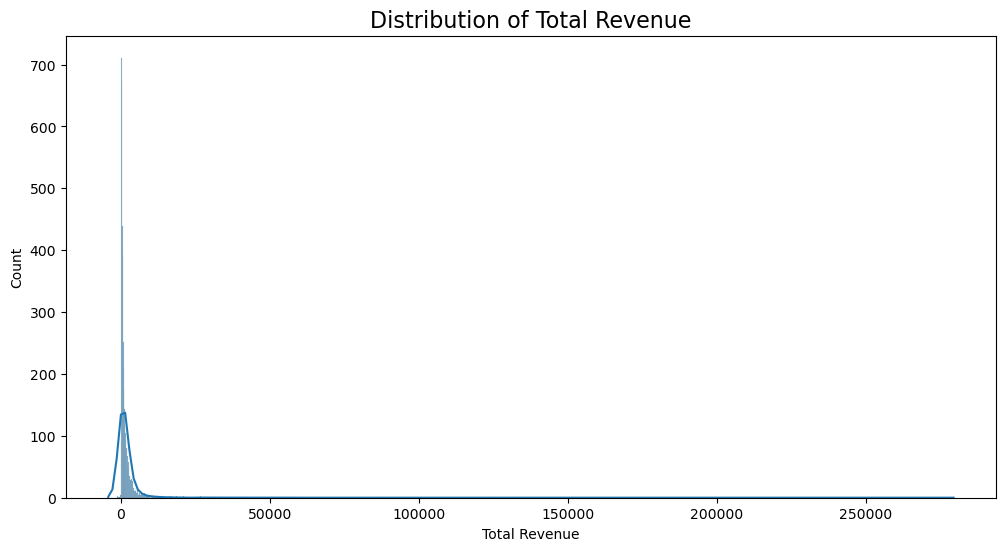

In [ ]:

plt.figure(figsize=(12,6))   # Increase graph size

sns.histplot(features['TotalRevenue'], kde=True)

plt.title("Distribution of Total Revenue", fontsize=16)
plt.xlabel("Total Revenue")
plt.ylabel("Count")
plt.show()



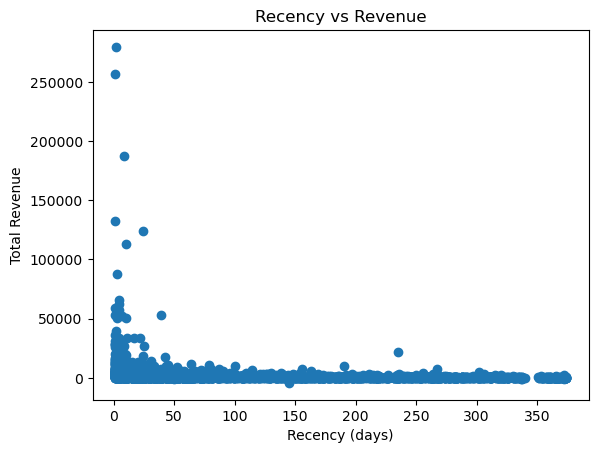

In [ ]:
plt.scatter(features['Recency'], features['TotalRevenue'])
plt.xlabel("Recency (days)")
plt.ylabel("Total Revenue")
plt.title("Recency vs Revenue")
plt.show()

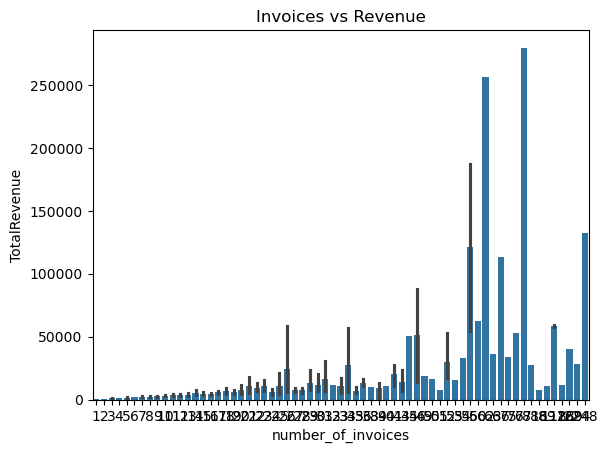

In [ ]:
sns.barplot(x='number_of_invoices', y='TotalRevenue', data=features)
plt.title("Invoices vs Revenue")
plt.show()

In [ ]:
# sns.barplot(x='Country', y='TotalRevenue', data=features)
# plt.xticks(rotation=45)
# plt.title("Revenue by Country")
# plt.show()

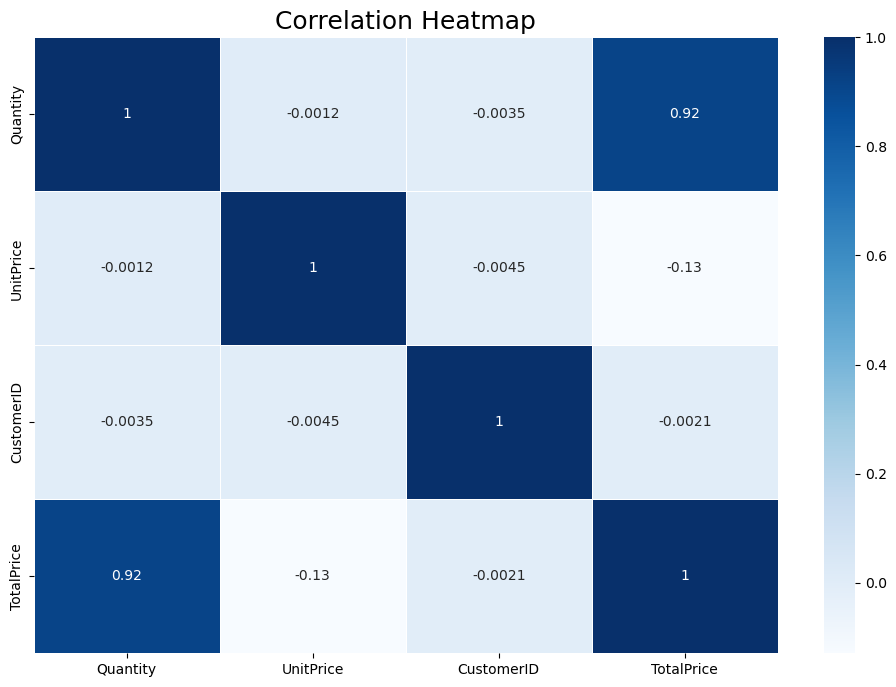

In [ ]:
plt.figure(figsize=(12,8))
numeric_df = df.select_dtypes(include=['float64', 'int64'])
sns.heatmap(numeric_df.corr(), annot=True, cmap="Blues", linewidths=0.5)
plt.title("Correlation Heatmap", fontsize=18)
plt.show()

## 🔀 Train-Test Split

The dataset is split into training and testing sets to evaluate model performance on unseen data and reduce overfitting.


In [ ]:
X = features[['Recency', 'number_of_invoices', 'Spent_Amount']]
y = features['TotalRevenue']

## 🤖 Model Selection

A regression-based machine learning model is selected to predict continuous CLV values.  
The model choice balances performance, interpretability, and practical business use.


In [ ]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

## 🏋️ Model Training

The selected model is trained using the training dataset.  
This step allows the model to learn relationships between RFM features and Customer Lifetime Value.


In [ ]:

model = XGBRegressor(n_estimators=900, learning_rate=0.04, max_depth=8)
model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.04, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=900, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [ ]:
y_pred = model.predict(X_test)
y_pred

array([ 8.93127686e+02,  4.10906647e+02,  1.07468544e+02,  4.97017181e+02,
        7.49212524e+02,  4.68817719e+02,  4.54485382e+02,  5.77879883e+02,
        3.66438818e+03,  9.41920013e+01,  1.86359192e+02,  3.53926666e+02,
        3.63698761e+02,  1.06037134e+03,  1.35041504e+02,  5.29293604e+03,
        3.83602722e+02,  1.86293884e+02,  8.80069122e+01,  4.50054108e+02,
        9.90891037e+01,  5.50167603e+02,  2.08340259e+03,  6.82445740e+02,
        5.70876099e+02,  3.79672150e+02,  6.72061707e+02,  6.67292725e+02,
        4.20436859e+02,  1.31298621e+03,  4.91395117e+03,  2.08431427e+02,
        1.74408740e+03,  5.98911377e+02,  7.81320801e+02,  7.12508423e+02,
        3.86250977e+02,  5.66629590e+03,  3.48871277e+02,  6.92079224e+02,
        4.56905640e+02,  1.56462671e+03,  5.71213750e+04,  4.00167297e+02,
        5.63337463e+02,  2.36853662e+03,  6.51027649e+02,  7.56487610e+02,
        7.72993896e+02,  1.74008777e+03,  2.32359131e+03,  6.11536804e+02,
        2.66930176e+02,  

## 📈 Results and Interpretation

The evaluation results indicate that the model can reasonably estimate Customer Lifetime Value based on customer purchasing behavior.

Such predictions can assist businesses in identifying high-value customers and optimizing marketing strategies.


In [ ]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R² Score:", r2)

Mean Absolute Error (MAE): 80.03397086004848
Mean Squared Error (MSE): 2325344.644110997
Root Mean Squared Error (RMSE): 1524.90807726597
R² Score: 0.9668418133106973


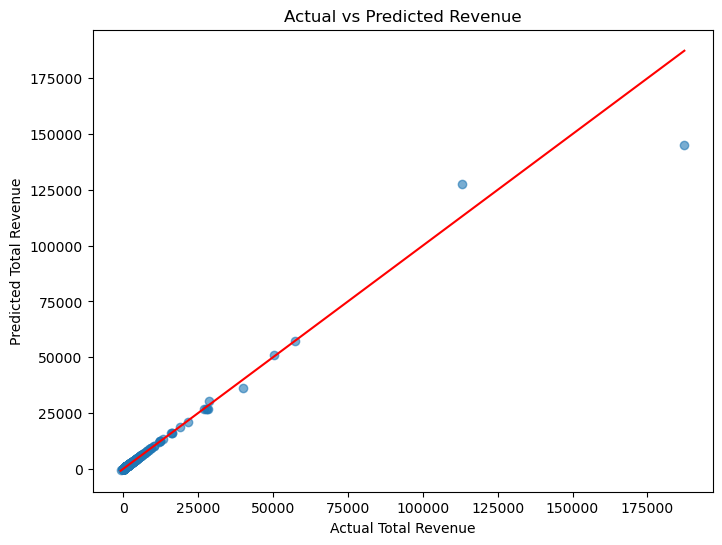

In [ ]:

plt.figure(figsize=(8,6))

plt.scatter(y_test, y_pred, alpha=0.6)
plt.xlabel("Actual Total Revenue")
plt.ylabel("Predicted Total Revenue")
plt.title("Actual vs Predicted Revenue")

# Perfect prediction line
min_val = min(min(y_test), min(y_pred))
max_val = max(max(y_test), max(y_pred))
plt.plot([min_val, max_val], [min_val, max_val], color="red")

plt.show()


In [ ]:

rf_reg = RandomForestRegressor(
    n_estimators=1000,
    random_state=40,
)

rf_reg.fit(X_train, y_train)

RandomForestRegressor(n_estimators=1000, random_state=40)

In [ ]:
y_pred1 = rf_reg.predict(X_test)


mae = mean_absolute_error(y_test, y_pred1)
mse = mean_squared_error(y_test, y_pred1)
r2 = r2_score(y_test, y_pred1)

print("MAE:", mae)
print("RMSE:", rmse)
print("R2:",r2)

MAE: 73.92860097142778
RMSE: 1524.90807726597
R2: 0.978780847280294


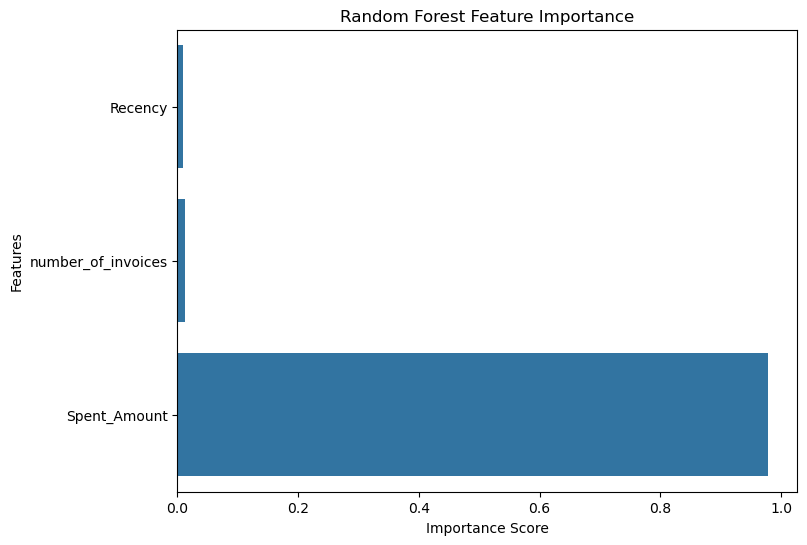

In [ ]:
importances = rf_reg.feature_importances_
feature_names = X_train.columns

plt.figure(figsize=(8,6))
sns.barplot(x=importances, y=feature_names)
plt.title("Random Forest Feature Importance")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.show()

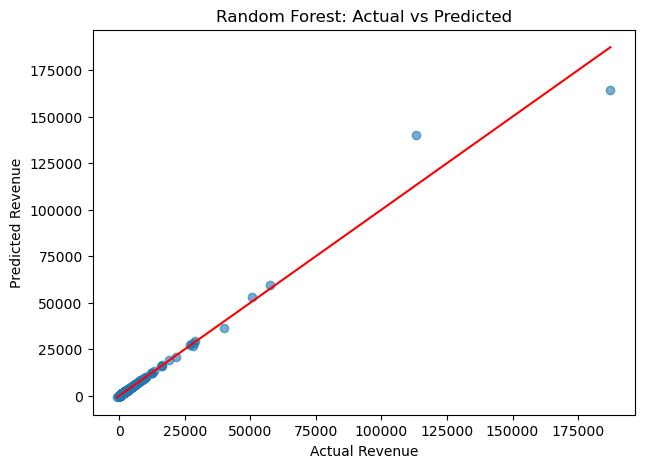

In [ ]:
plt.figure(figsize=(7,5))
plt.scatter(y_test, y_pred1, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color="red")
plt.xlabel("Actual Revenue")
plt.ylabel("Predicted Revenue")
plt.title("Random Forest: Actual vs Predicted")
plt.show()


## 💾 Model Saving

The trained machine learning model is saved using serialization techniques so that it can be reused in deployment environments such as web applications.


In [ ]:
filename='model.pkl'
pickle.dump(rf_reg,open(filename,'wb'))

In [ ]:
load_model=pickle.load(open(filename,'rb'))

In [ ]:
load_model.score(X_test,y_test)

0.978780847280294

In [ ]:
rf_reg.feature_names_in_

array(['Recency', 'number_of_invoices', 'Spent_Amount'], dtype=object)

In [ ]:

model2 = LinearRegression()
model2.fit(X_train, y_train)
y_pred2 = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred2)
mse = mean_squared_error(y_test, y_pred2)
r2 = r2_score(y_test, y_pred2)

print("MAE:", mae)
print("MSE:", mse)
print("R2 Score:", r2)

MAE: 80.03397086004848
MSE: 2325344.644110997
R2 Score: 0.9668418133106973


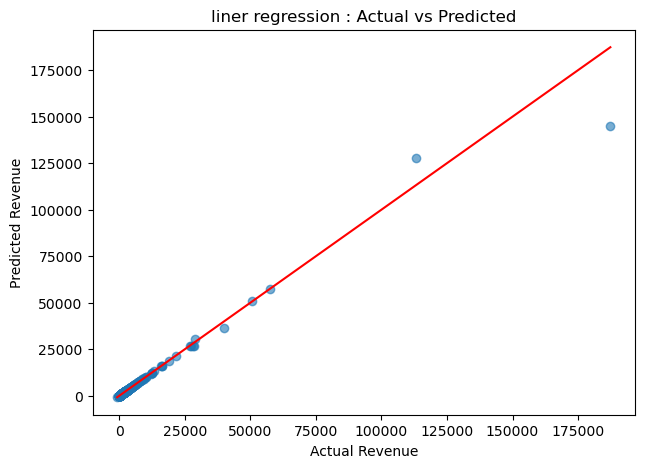

In [ ]:
plt.figure(figsize=(7,5))
plt.scatter(y_test, y_pred2, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color="red")
plt.xlabel("Actual Revenue")
plt.ylabel("Predicted Revenue")
plt.title("liner regression : Actual vs Predicted")
plt.show()


## ✅ Conclusion

This project demonstrates an end-to-end machine learning workflow for predicting Customer Lifetime Value using RFM analysis.  
The developed model provides valuable insights into customer behavior and supports data-driven decision-making for business growth.


## 🚀 Future Enhancements

- Incorporating additional behavioral and demographic features  
- Trying advanced models such as Gradient Boosting or XGBoost  
- Adding explainability techniques like SHAP values  
- Deploying the model as a production-ready web application  
